In [1]:
%cd /nfsd/sysbiobig/bazzaccoen/tangramlit_dev

/nfsd/sysbiobig/bazzaccoen/tangramlit_dev


In [2]:
import tangramlit as tgl

/nfsd/sysbiobig/bazzaccoen/tangramlit_dev/myvenv/lib64/python3.12/site-packages/dask/dataframe/__init__.py:31: FutureWarning: The legacy Dask DataFrame implementation is deprecated and will be removed in a future version. Set the configuration option `dataframe.query-planning` to `True` or None to enable the new Dask Dataframe implementation and silence this warning.
  warnings.warn(
/nfsd/sysbiobig/bazzaccoen/tangramlit_dev/myvenv/lib64/python3.12/site-packages/xarray_schema/__init__.py:1: UserWarning: pkg_resources is deprecated as an API. See https://setuptools.pypa.io/en/latest/pkg_resources.html. The pkg_resources package is slated for removal as early as 2025-11-30. Refrain from using this package or pin to Setuptools<81.
  from pkg_resources import DistributionNotFound, get_distribution
/nfsd/sysbiobig/bazzaccoen/tangramlit_dev/myvenv/lib64/python3.12/site-packages/anndata/utils.py:434: FutureWarning: Importing read_text from `anndata` is deprecated. Import anndata.io.read_text 

In [2]:
import scanpy as sc
import numpy as np 
import anndata as ad
import pandas as pd
import yaml

# Data Loading

In [ ]:
# Set data path
data_path = "/nfsd/sysbiobig/bazzaccoen/tangramlit_dev/data/Dataset1/"

In [5]:
adata_sc = sc.read_h5ad(data_path + "scRNA_data.h5ad")
adata_sc

AnnData object with n_obs × n_vars = 4651 × 29452
    obs: 'cell', 'barcode', 'sample', 'pool', 'stage', 'sequencing.batch', 'theiler', 'doub.density', 'doublet', 'cluster', 'cluster.sub', 'cluster.stage', 'cluster.theiler', 'stripped', 'celltype', 'colour'
    var: 'ENSEMBL', 'SYMBOL'
    uns: 'X_name'

In [ ]:
adata_st = sc.read(data_path + "seqFISH_data.h5ad")
adata_st

AnnData object with n_obs × n_vars = 57536 × 351
    obs: 'uniqueID', 'embryo', 'pos', 'z', 'x_global', 'y_global', 'x_global_affine', 'y_global_affine', 'embryo_pos', 'embryo_pos_z', 'Area', 'UMAP1', 'UMAP2', 'celltype_mapped_refined'
    var: 'gene_id'
    uns: '.colData', 'X_name'
    obsm: 'spatial'
    layers: 'logcounts'

# Config

In [7]:
# Read config yaml
with open("data/Dataset1/train_config.yaml", "r") as f:
        config = yaml.safe_load(f)

config  # contains rng seed

{'cluster_label': 'celltype',
 'lambda_count': 1e-05,
 'lambda_ct_islands': 1,
 'lambda_d': 0.001,
 'lambda_f_reg': 1e-05,
 'lambda_g1': 1,
 'lambda_g2': 1,
 'lambda_geary': 1,
 'lambda_getis_ord': 1,
 'lambda_l1': 1e-15,
 'lambda_l2': 1e-18,
 'lambda_moran': 1,
 'lambda_neighborhood_g1': 1,
 'lambda_r': 1e-09,
 'lambda_sparsity_g1': 1,
 'learning_rate': 0.1,
 'filter': False,
 'num_epochs': 1000,
 'random_state': 42,
 'target_count': None}

## Train/Val split

In [8]:
# Get shared genes (case-insensitive)
sc_genes = {gene.lower(): gene for gene in adata_sc.var_names}
st_genes = {gene.lower(): gene for gene in adata_st.var_names}

# Find intersection of lowercase gene names
shared_genes_set = set(sc_genes.keys()) & set(st_genes.keys())
shared_genes = [gene_lower for gene_lower in shared_genes_set]

# Shuffle the shared genes
shared_genes = np.array(shared_genes)
np.random.seed(config['random_state'])
np.random.shuffle(shared_genes)

# Split into train and validation
train_ratio = 0.8
n_train = int(len(shared_genes) * train_ratio)
train_genes = shared_genes[:n_train]
val_genes = shared_genes[n_train:]

print(len(train_genes), "training genes: ", train_genes[0:10], "...")
print(len(val_genes), "validation genes: ", val_genes[0:10], "...")

280 training genes:  ['hand1' 'mrap' 'atp1b1' 'alas2' 'sfmbt2' 'prrx1' 'fzd2' 'pcgf3' 'wnt3a'
 'hoxa13'] ...
70 validation genes:  ['isl1' 'cpn1' 'hoxb8' 'bin2' 'gfi1b' 'fli1' 'irx1' 'tinagl1' 'epor'
 'setd1b'] ...


# Optuna

In [9]:
config['num_epochs'] = 50  # decrease for optuna tuning
config

{'cluster_label': 'celltype',
 'lambda_count': 1e-05,
 'lambda_ct_islands': 1,
 'lambda_d': 0.001,
 'lambda_f_reg': 1e-05,
 'lambda_g1': 1,
 'lambda_g2': 1,
 'lambda_geary': 1,
 'lambda_getis_ord': 1,
 'lambda_l1': 1e-15,
 'lambda_l2': 1e-18,
 'lambda_moran': 1,
 'lambda_neighborhood_g1': 1,
 'lambda_r': 1e-09,
 'lambda_sparsity_g1': 1,
 'learning_rate': 0.1,
 'filter': False,
 'num_epochs': 50,
 'random_state': 42,
 'target_count': None}

In [10]:
study_name = "tangram_tuning_Dataset1_no_filtering"
study_path = "/nfsd/sysbiobig/bazzaccoen/tangramlit_dev/results/Dataset1/"
storage = f"sqlite:///{study_path}{study_name}.db"
n_trials = 20
resume = True

In [12]:
best_params, trials_df = tgl.tune_loss_coefficients(
        adata_sc=adata_sc,
        adata_st=adata_st,
        input_genes=None,
        train_genes_names=train_genes,
        val_genes_names=val_genes,
        **config,
        study_name=study_name,
        storage=storage,
        n_trials=n_trials,
        timeout=None,
        resume=resume,
        )

[I 2025-11-05 23:39:23,453] A new study created in RDB with name: tangram_tuning_Dataset1_no_filtering
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs

  | Name               | Type      | Params | Mode 
---------------------------------------------------------
0 | _density_criterion | KLDivLoss | 0      | train
  | other params       | n/a       | 4.8 M  | n/a  
---------------------------------------------------------
4.8 M     Trainable params
0         Non-trainable params
4.8 M     Total params
19.052    Total estimated model params size (MB)
1         Modules in train mode
0         Modules in eval mode



Validating with 69 genes
S matrix shape: torch.Size([3661, 69])
G matrix shape: torch.Size([1301, 69])

Training with 276 genes
S matrix shape: torch.Size([3661, 276])
G matrix shape: torch.Size([1301, 276])


`Trainer.fit` stopped: `max_epochs=50` reached.
[I 2025-11-05 23:46:02,620] Trial 0 finished with value: 1.000725507736206 and parameters: {'lambda_d': 0.0001274145557755541, 'lambda_g2': 0.6609573047684897, 'lambda_r': 2.368957835384474e-05, 'lambda_l1': 1.1155473940945057e-17, 'lambda_l2': 1.9394849819829963e-15, 'lambda_neighborhood_g1': 0.013746599519149773, 'lambda_getis_ord': 0.13641804002167732, 'lambda_moran': 2.246076488576992, 'lambda_geary': 0.0772340018510946, 'lambda_ct_islands': 0.41097999375658706}. Best is trial 0 with value: 1.000725507736206.
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs

  | Name               | Type      | Params | Mode 
---------------------------------------------------------
0 | _density_criterion | KLDivLoss | 0      | train
  | other params       | n/a       | 4.8 M  | n/a  
---------------------------------------------------------
4.8 M     Trainable params
0         Non-trainabl


Validating with 69 genes
S matrix shape: torch.Size([3661, 69])
G matrix shape: torch.Size([1301, 69])

Training with 276 genes
S matrix shape: torch.Size([3661, 276])
G matrix shape: torch.Size([1301, 276])


`Trainer.fit` stopped: `max_epochs=50` reached.
[I 2025-11-05 23:52:38,545] Trial 1 finished with value: 1.1384882926940918 and parameters: {'lambda_d': 0.0003502251155875146, 'lambda_g2': 0.13030893498227464, 'lambda_r': 7.182509601181529e-08, 'lambda_l1': 1.0521827116409215e-18, 'lambda_l2': 1.6226780870411552e-20, 'lambda_neighborhood_g1': 6.92831178214073, 'lambda_getis_ord': 0.029021364171428792, 'lambda_moran': 0.04333034494810104, 'lambda_geary': 0.026124550085242643, 'lambda_ct_islands': 0.04329922857715575}. Best is trial 1 with value: 1.1384882926940918.
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs

  | Name               | Type      | Params | Mode 
---------------------------------------------------------
0 | _density_criterion | KLDivLoss | 0      | train
  | other params       | n/a       | 4.8 M  | n/a  
---------------------------------------------------------
4.8 M     Trainable params
0         Non-trai


Validating with 69 genes
S matrix shape: torch.Size([3661, 69])
G matrix shape: torch.Size([1301, 69])

Training with 276 genes
S matrix shape: torch.Size([3661, 276])
G matrix shape: torch.Size([1301, 276])


[I 2025-11-05 23:53:14,477] Trial 2 pruned. Trial was pruned at epoch 3.
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs

  | Name               | Type      | Params | Mode 
---------------------------------------------------------
0 | _density_criterion | KLDivLoss | 0      | train
  | other params       | n/a       | 4.8 M  | n/a  
---------------------------------------------------------
4.8 M     Trainable params
0         Non-trainable params
4.8 M     Total params
19.052    Total estimated model params size (MB)
1         Modules in train mode
0         Modules in eval mode



Validating with 69 genes
S matrix shape: torch.Size([3661, 69])
G matrix shape: torch.Size([1301, 69])

Training with 276 genes
S matrix shape: torch.Size([3661, 276])
G matrix shape: torch.Size([1301, 276])


[I 2025-11-05 23:53:49,400] Trial 3 pruned. Trial was pruned at epoch 3.
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs

  | Name               | Type      | Params | Mode 
---------------------------------------------------------
0 | _density_criterion | KLDivLoss | 0      | train
  | other params       | n/a       | 4.8 M  | n/a  
---------------------------------------------------------
4.8 M     Trainable params
0         Non-trainable params
4.8 M     Total params
19.052    Total estimated model params size (MB)
1         Modules in train mode
0         Modules in eval mode



Validating with 69 genes
S matrix shape: torch.Size([3661, 69])
G matrix shape: torch.Size([1301, 69])

Training with 276 genes
S matrix shape: torch.Size([3661, 276])
G matrix shape: torch.Size([1301, 276])


[I 2025-11-05 23:56:29,939] Trial 4 pruned. Trial was pruned at epoch 19.
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs

  | Name               | Type      | Params | Mode 
---------------------------------------------------------
0 | _density_criterion | KLDivLoss | 0      | train
  | other params       | n/a       | 4.8 M  | n/a  
---------------------------------------------------------
4.8 M     Trainable params
0         Non-trainable params
4.8 M     Total params
19.052    Total estimated model params size (MB)
1         Modules in train mode
0         Modules in eval mode



Validating with 69 genes
S matrix shape: torch.Size([3661, 69])
G matrix shape: torch.Size([1301, 69])

Training with 276 genes
S matrix shape: torch.Size([3661, 276])
G matrix shape: torch.Size([1301, 276])


[I 2025-11-05 23:57:05,755] Trial 5 pruned. Trial was pruned at epoch 3.
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs

  | Name               | Type      | Params | Mode 
---------------------------------------------------------
0 | _density_criterion | KLDivLoss | 0      | train
  | other params       | n/a       | 4.8 M  | n/a  
---------------------------------------------------------
4.8 M     Trainable params
0         Non-trainable params
4.8 M     Total params
19.052    Total estimated model params size (MB)
1         Modules in train mode
0         Modules in eval mode



Validating with 69 genes
S matrix shape: torch.Size([3661, 69])
G matrix shape: torch.Size([1301, 69])

Training with 276 genes
S matrix shape: torch.Size([3661, 276])
G matrix shape: torch.Size([1301, 276])


[I 2025-11-05 23:57:40,792] Trial 6 pruned. Trial was pruned at epoch 3.
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs

  | Name               | Type      | Params | Mode 
---------------------------------------------------------
0 | _density_criterion | KLDivLoss | 0      | train
  | other params       | n/a       | 4.8 M  | n/a  
---------------------------------------------------------
4.8 M     Trainable params
0         Non-trainable params
4.8 M     Total params
19.052    Total estimated model params size (MB)
1         Modules in train mode
0         Modules in eval mode



Validating with 69 genes
S matrix shape: torch.Size([3661, 69])
G matrix shape: torch.Size([1301, 69])

Training with 276 genes
S matrix shape: torch.Size([3661, 276])
G matrix shape: torch.Size([1301, 276])


[I 2025-11-05 23:58:47,427] Trial 7 pruned. Trial was pruned at epoch 7.
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs

  | Name               | Type      | Params | Mode 
---------------------------------------------------------
0 | _density_criterion | KLDivLoss | 0      | train
  | other params       | n/a       | 4.8 M  | n/a  
---------------------------------------------------------
4.8 M     Trainable params
0         Non-trainable params
4.8 M     Total params
19.052    Total estimated model params size (MB)
1         Modules in train mode
0         Modules in eval mode



Validating with 69 genes
S matrix shape: torch.Size([3661, 69])
G matrix shape: torch.Size([1301, 69])

Training with 276 genes
S matrix shape: torch.Size([3661, 276])
G matrix shape: torch.Size([1301, 276])


[I 2025-11-05 23:59:55,274] Trial 8 pruned. Trial was pruned at epoch 7.
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs

  | Name               | Type      | Params | Mode 
---------------------------------------------------------
0 | _density_criterion | KLDivLoss | 0      | train
  | other params       | n/a       | 4.8 M  | n/a  
---------------------------------------------------------
4.8 M     Trainable params
0         Non-trainable params
4.8 M     Total params
19.052    Total estimated model params size (MB)
1         Modules in train mode
0         Modules in eval mode



Validating with 69 genes
S matrix shape: torch.Size([3661, 69])
G matrix shape: torch.Size([1301, 69])

Training with 276 genes
S matrix shape: torch.Size([3661, 276])
G matrix shape: torch.Size([1301, 276])


[I 2025-11-06 00:01:01,547] Trial 9 pruned. Trial was pruned at epoch 7.
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs

  | Name               | Type      | Params | Mode 
---------------------------------------------------------
0 | _density_criterion | KLDivLoss | 0      | train
  | other params       | n/a       | 4.8 M  | n/a  
---------------------------------------------------------
4.8 M     Trainable params
0         Non-trainable params
4.8 M     Total params
19.052    Total estimated model params size (MB)
1         Modules in train mode
0         Modules in eval mode



Validating with 69 genes
S matrix shape: torch.Size([3661, 69])
G matrix shape: torch.Size([1301, 69])

Training with 276 genes
S matrix shape: torch.Size([3661, 276])
G matrix shape: torch.Size([1301, 276])


[I 2025-11-06 00:02:08,709] Trial 10 pruned. Trial was pruned at epoch 7.
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs

  | Name               | Type      | Params | Mode 
---------------------------------------------------------
0 | _density_criterion | KLDivLoss | 0      | train
  | other params       | n/a       | 4.8 M  | n/a  
---------------------------------------------------------
4.8 M     Trainable params
0         Non-trainable params
4.8 M     Total params
19.052    Total estimated model params size (MB)
1         Modules in train mode
0         Modules in eval mode



Validating with 69 genes
S matrix shape: torch.Size([3661, 69])
G matrix shape: torch.Size([1301, 69])

Training with 276 genes
S matrix shape: torch.Size([3661, 276])
G matrix shape: torch.Size([1301, 276])


[I 2025-11-06 00:02:43,597] Trial 11 pruned. Trial was pruned at epoch 3.
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs

  | Name               | Type      | Params | Mode 
---------------------------------------------------------
0 | _density_criterion | KLDivLoss | 0      | train
  | other params       | n/a       | 4.8 M  | n/a  
---------------------------------------------------------
4.8 M     Trainable params
0         Non-trainable params
4.8 M     Total params
19.052    Total estimated model params size (MB)
1         Modules in train mode
0         Modules in eval mode



Validating with 69 genes
S matrix shape: torch.Size([3661, 69])
G matrix shape: torch.Size([1301, 69])

Training with 276 genes
S matrix shape: torch.Size([3661, 276])
G matrix shape: torch.Size([1301, 276])


[I 2025-11-06 00:03:18,651] Trial 12 pruned. Trial was pruned at epoch 3.
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs

  | Name               | Type      | Params | Mode 
---------------------------------------------------------
0 | _density_criterion | KLDivLoss | 0      | train
  | other params       | n/a       | 4.8 M  | n/a  
---------------------------------------------------------
4.8 M     Trainable params
0         Non-trainable params
4.8 M     Total params
19.052    Total estimated model params size (MB)
1         Modules in train mode
0         Modules in eval mode



Validating with 69 genes
S matrix shape: torch.Size([3661, 69])
G matrix shape: torch.Size([1301, 69])

Training with 276 genes
S matrix shape: torch.Size([3661, 276])
G matrix shape: torch.Size([1301, 276])


[I 2025-11-06 00:03:54,972] Trial 13 pruned. Trial was pruned at epoch 3.
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs

  | Name               | Type      | Params | Mode 
---------------------------------------------------------
0 | _density_criterion | KLDivLoss | 0      | train
  | other params       | n/a       | 4.8 M  | n/a  
---------------------------------------------------------
4.8 M     Trainable params
0         Non-trainable params
4.8 M     Total params
19.052    Total estimated model params size (MB)
1         Modules in train mode
0         Modules in eval mode



Validating with 69 genes
S matrix shape: torch.Size([3661, 69])
G matrix shape: torch.Size([1301, 69])

Training with 276 genes
S matrix shape: torch.Size([3661, 276])
G matrix shape: torch.Size([1301, 276])


[I 2025-11-06 00:05:01,118] Trial 14 pruned. Trial was pruned at epoch 7.
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs

  | Name               | Type      | Params | Mode 
---------------------------------------------------------
0 | _density_criterion | KLDivLoss | 0      | train
  | other params       | n/a       | 4.8 M  | n/a  
---------------------------------------------------------
4.8 M     Trainable params
0         Non-trainable params
4.8 M     Total params
19.052    Total estimated model params size (MB)
1         Modules in train mode
0         Modules in eval mode



Validating with 69 genes
S matrix shape: torch.Size([3661, 69])
G matrix shape: torch.Size([1301, 69])

Training with 276 genes
S matrix shape: torch.Size([3661, 276])
G matrix shape: torch.Size([1301, 276])


[I 2025-11-06 00:05:36,251] Trial 15 pruned. Trial was pruned at epoch 3.
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs

  | Name               | Type      | Params | Mode 
---------------------------------------------------------
0 | _density_criterion | KLDivLoss | 0      | train
  | other params       | n/a       | 4.8 M  | n/a  
---------------------------------------------------------
4.8 M     Trainable params
0         Non-trainable params
4.8 M     Total params
19.052    Total estimated model params size (MB)
1         Modules in train mode
0         Modules in eval mode



Validating with 69 genes
S matrix shape: torch.Size([3661, 69])
G matrix shape: torch.Size([1301, 69])

Training with 276 genes
S matrix shape: torch.Size([3661, 276])
G matrix shape: torch.Size([1301, 276])


`Trainer.fit` stopped: `max_epochs=50` reached.
[I 2025-11-06 00:12:11,886] Trial 16 finished with value: 1.137009859085083 and parameters: {'lambda_d': 0.0001534211398771219, 'lambda_g2': 0.17653703190361372, 'lambda_r': 8.146566210802553e-07, 'lambda_l1': 4.0914162434160866e-18, 'lambda_l2': 1.032638766471652e-21, 'lambda_neighborhood_g1': 0.15233329292973566, 'lambda_getis_ord': 0.012024247323426432, 'lambda_moran': 0.026043334005604053, 'lambda_geary': 0.12325269074189266, 'lambda_ct_islands': 0.03487111797395461}. Best is trial 1 with value: 1.1384882926940918.
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs

  | Name               | Type      | Params | Mode 
---------------------------------------------------------
0 | _density_criterion | KLDivLoss | 0      | train
  | other params       | n/a       | 4.8 M  | n/a  
---------------------------------------------------------
4.8 M     Trainable params
0         Non-tr


Validating with 69 genes
S matrix shape: torch.Size([3661, 69])
G matrix shape: torch.Size([1301, 69])

Training with 276 genes
S matrix shape: torch.Size([3661, 276])
G matrix shape: torch.Size([1301, 276])


`Trainer.fit` stopped: `max_epochs=50` reached.
[I 2025-11-06 00:18:48,781] Trial 17 finished with value: 1.13508141040802 and parameters: {'lambda_d': 3.8656167580326274e-05, 'lambda_g2': 0.3248512153376864, 'lambda_r': 1.6172364022774072e-06, 'lambda_l1': 2.389686381500733e-18, 'lambda_l2': 9.861897297763294e-20, 'lambda_neighborhood_g1': 0.07743469866837391, 'lambda_getis_ord': 0.16752884821699807, 'lambda_moran': 0.05725929600883713, 'lambda_geary': 0.1985441808467796, 'lambda_ct_islands': 0.07712759837386148}. Best is trial 1 with value: 1.1384882926940918.
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs

  | Name               | Type      | Params | Mode 
---------------------------------------------------------
0 | _density_criterion | KLDivLoss | 0      | train
  | other params       | n/a       | 4.8 M  | n/a  
---------------------------------------------------------
4.8 M     Trainable params
0         Non-traina


Validating with 69 genes
S matrix shape: torch.Size([3661, 69])
G matrix shape: torch.Size([1301, 69])

Training with 276 genes
S matrix shape: torch.Size([3661, 276])
G matrix shape: torch.Size([1301, 276])


`Trainer.fit` stopped: `max_epochs=50` reached.
[I 2025-11-06 00:25:24,903] Trial 18 finished with value: 1.1382005214691162 and parameters: {'lambda_d': 3.23388177214135e-05, 'lambda_g2': 0.19326198838017267, 'lambda_r': 5.168641440320081e-08, 'lambda_l1': 2.363452878158836e-18, 'lambda_l2': 1.5254228686722987e-21, 'lambda_neighborhood_g1': 0.5351717263740258, 'lambda_getis_ord': 0.013910911217832118, 'lambda_moran': 0.02609553112595086, 'lambda_geary': 0.162559212465926, 'lambda_ct_islands': 0.026295798984115125}. Best is trial 1 with value: 1.1384882926940918.
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs

  | Name               | Type      | Params | Mode 
---------------------------------------------------------
0 | _density_criterion | KLDivLoss | 0      | train
  | other params       | n/a       | 4.8 M  | n/a  
---------------------------------------------------------
4.8 M     Trainable params
0         Non-train


Validating with 69 genes
S matrix shape: torch.Size([3661, 69])
G matrix shape: torch.Size([1301, 69])

Training with 276 genes
S matrix shape: torch.Size([3661, 276])
G matrix shape: torch.Size([1301, 276])


[I 2025-11-06 00:26:00,526] Trial 19 pruned. Trial was pruned at epoch 3.


Best trial:
  Value: 1.1384882926940918
  Params:
    lambda_d: 0.0003502251155875146
    lambda_g2: 0.13030893498227464
    lambda_r: 7.182509601181529e-08
    lambda_l1: 1.0521827116409215e-18
    lambda_l2: 1.6226780870411552e-20
    lambda_neighborhood_g1: 6.92831178214073
    lambda_getis_ord: 0.029021364171428792
    lambda_moran: 0.04333034494810104
    lambda_geary: 0.026124550085242643
    lambda_ct_islands: 0.04329922857715575


In [23]:
help(tgl.validate_mapping_inputs)

Help on function validate_mapping_inputs in module tangramlit.mapping_utils:

validate_mapping_inputs(adata_sc, adata_st, input_genes, train_genes_names, val_genes_names, filter, learning_rate=0.1, num_epochs=1000, random_state=None, lambda_d=0, lambda_g1=1, lambda_g2=0, lambda_r=0, lambda_l1=0, lambda_l2=0, lambda_count=1, lambda_f_reg=1, target_count=None, lambda_sparsity_g1=0, lambda_neighborhood_g1=0, lambda_getis_ord=0, lambda_moran=0, lambda_geary=0, lambda_ct_islands=0, cluster_label=None)
    Validates inputs for cell-to-space mapping functions in the Tangram framework.

    Args:
        Same as map_cells_to_space()

    Returns:
        hyperparameters (dict): Dictionary of hyperparameters for the LightningModule training.
        Includes: filter, num_epochs, learning_rate, random_state, all lambdas, targe_count, cluster_label.
        Weights for refinement terms are added in map_cells_to_space().
        The anndata objects and gene indexes are only validated (not returned

In [13]:
trials_df

,number,value,datetime_start,datetime_complete,duration,params_lambda_ct_islands,params_lambda_d,params_lambda_g2,params_lambda_geary,params_lambda_getis_ord,params_lambda_l1,params_lambda_l2,params_lambda_moran,params_lambda_neighborhood_g1,params_lambda_r,system_attrs_completed_rung_0,system_attrs_completed_rung_1,system_attrs_completed_rung_2,state
0,0,1.000726,2025-11-05 23:39:23.472045,2025-11-05 23:46:02.576422,0 days 00:06:39.104377,0.410980,0.000127,0.660957,0.077234,0.136418,1.115547e-17,1.939485e-15,2.246076,0.013747,2.368958e-05,0.443473,0.445609,0.451178,COMPLETE
1,1,1.138488,2025-11-05 23:46:02.649215,2025-11-05 23:52:38.510248,0 days 00:06:35.861033,0.043299,0.000350,0.130309,0.026125,0.029021,1.052183e-18,1.622678e-20,0.043330,6.928312,7.182510e-08,0.484745,0.509325,0.527867,COMPLETE
2,2,0.459958,2025-11-05 23:52:38.569258,2025-11-05 23:53:14.469187,0 days 00:00:35.899929,0.012986,0.000003,0.127227,7.081812,5.587773,2.669035e-16,5.032148e-15,0.282890,0.050021,1.533215e-08,0.459958,NaN,NaN,PRUNED
3,3,0.441616,2025-11-05 23:53:14.505255,2025-11-05 23:53:49.393214,0 days 00:00:34.887959,0.375012,0.000024,0.045071,0.186970,0.164004,8.500444e-18,6.418904e-18,3.039022,0.135013,2.606376e-05,0.441616,NaN,NaN,PRUNED
4,4,0.523816,2025-11-05 23:53:49.427819,2025-11-05 23:56:29.932463,0 days 00:02:40.504644,0.023230,0.000092,0.346627,0.361453,0.104529,3.547782e-14,2.638558e-20,0.082747,0.782732,4.783899e-05,0.486070,0.511854,0.523816,PRUNED
5,5,0.473791,2025-11-05 23:56:29.971117,2025-11-05 23:57:05.749172,0 days 00:00:35.778055,0.019745,0.000203,0.155159,0.019953,0.029595,4.749664e-18,9.401938e-19,0.515418,2.870026,3.919320e-06,0.473791,NaN,NaN,PRUNED
6,6,0.483385,2025-11-05 23:57:05.792872,2025-11-05 23:57:40.785609,0 days 00:00:34.992737,0.076478,0.000229,0.036242,1.268107,0.116025,3.333226e-18,3.837341e-21,0.049872,2.542481,1.160055e-08,0.483385,NaN,NaN,PRUNED
7,7,0.509371,2025-11-05 23:57:40.827539,2025-11-05 23:58:47.420168,0 days 00:01:06.592629,0.033408,0.000064,0.011542,0.021392,0.027539,1.374331e-17,1.226395e-21,0.035924,6.701725,1.233854e-08,0.484800,0.509371,NaN,PRUNED
8,8,0.510925,2025-11-05 23:58:47.452662,2025-11-05 23:59:55.263215,0 days 00:01:07.810553,0.032102,0.000343,0.766799,0.113674,0.198518,1.957450e-18,3.374137e-15,0.013909,5.341159,4.736040e-09,0.486035,0.510925,NaN,PRUNED
9,9,0.509506,2025-11-05 23:59:55.316949,2025-11-06 00:01:01.537846,0 days 00:01:06.220897,0.219344,0.000103,0.404096,0.205562,0.014406,1.890421e-18,9.756968e-19,0.031173,8.891140,4.632089e-07,0.484973,0.509506,NaN,PRUNED


<Axes: title={'center': 'Optimization History Plot'}, xlabel='Trial', ylabel='Objective Value'>

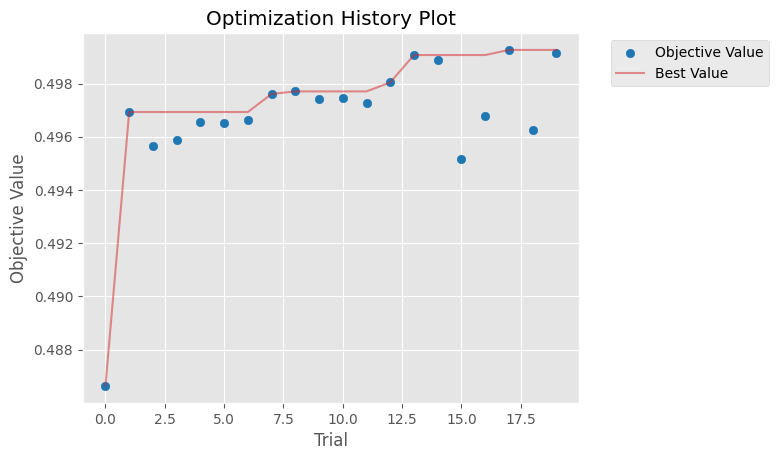

In [22]:
import optuna
from optuna.visualization.matplotlib import plot_optimization_history

study = optuna.load_study(study_name=study_name, storage=storage)
plot_optimization_history(study)


<Axes: title={'center': 'Optimization History Plot'}, xlabel='Trial', ylabel='Objective Value'>

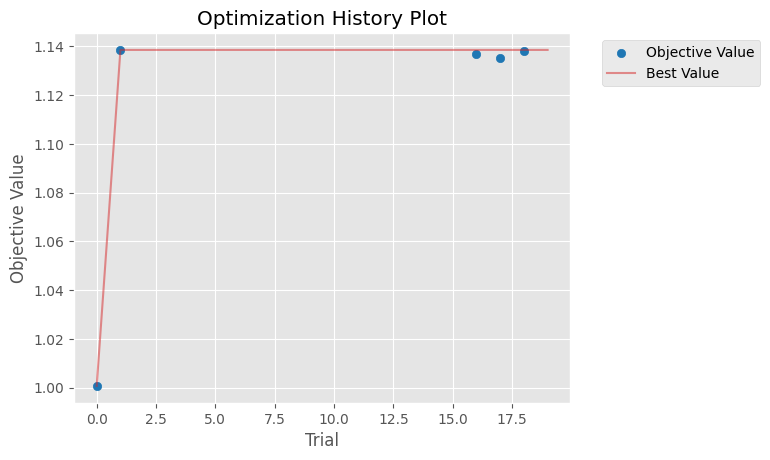

In [14]:
import optuna
from optuna.visualization.matplotlib import plot_optimization_history

study = optuna.load_study(study_name=study_name, storage=storage)
plot_optimization_history(study)

<Axes: title={'left': 'Hyperparameter Importances'}, xlabel='Hyperparameter Importance', ylabel='Hyperparameter'>

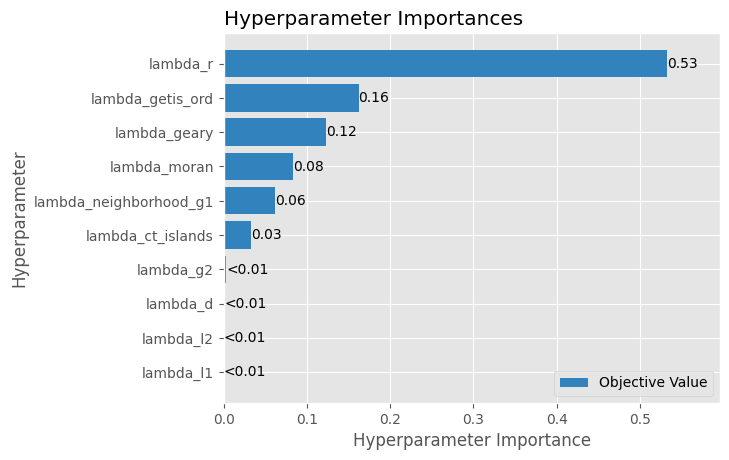

In [21]:
from optuna.visualization.matplotlib import plot_param_importances

plot_param_importances(study)


<Axes: title={'left': 'Hyperparameter Importances'}, xlabel='Hyperparameter Importance', ylabel='Hyperparameter'>

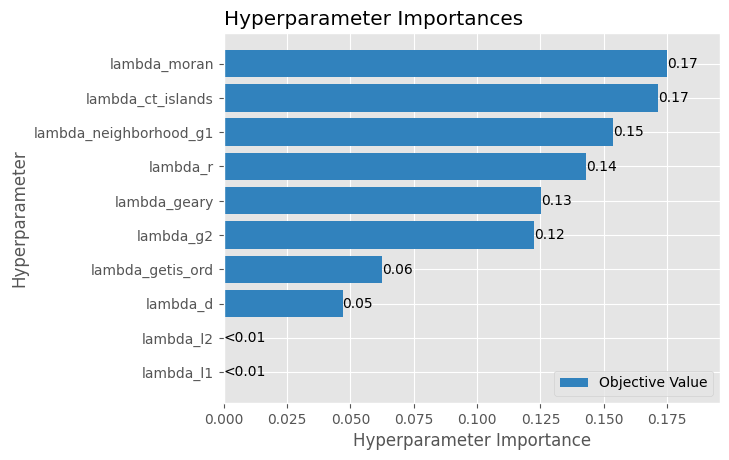

In [15]:
from optuna.visualization.matplotlib import plot_param_importances

plot_param_importances(study)

<Axes: title={'center': 'Contour Plot'}, xlabel='lambda_geary', ylabel='lambda_moran'>

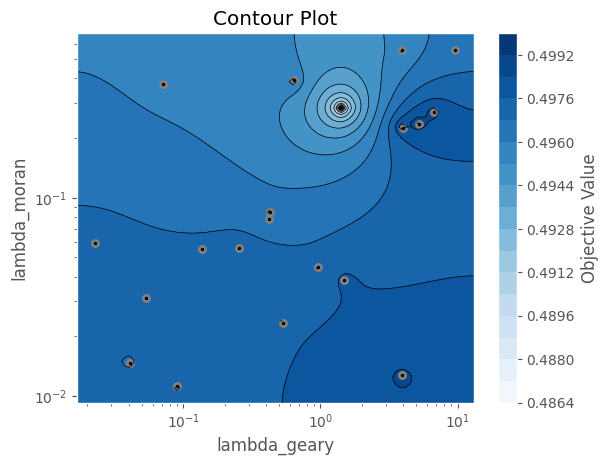

In [24]:
from optuna.visualization.matplotlib import plot_contour

plot_contour(study, params=['lambda_geary', 'lambda_moran'])

<Axes: title={'center': 'Contour Plot'}, xlabel='lambda_geary', ylabel='lambda_moran'>

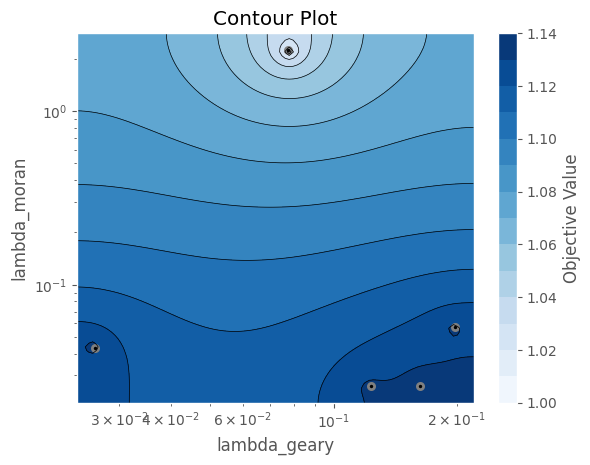

In [16]:
from optuna.visualization.matplotlib import plot_contour

plot_contour(study, params=['lambda_geary', 'lambda_moran'])

<Axes: title={'center': 'Contour Plot'}, xlabel='lambda_d', ylabel='lambda_r'>

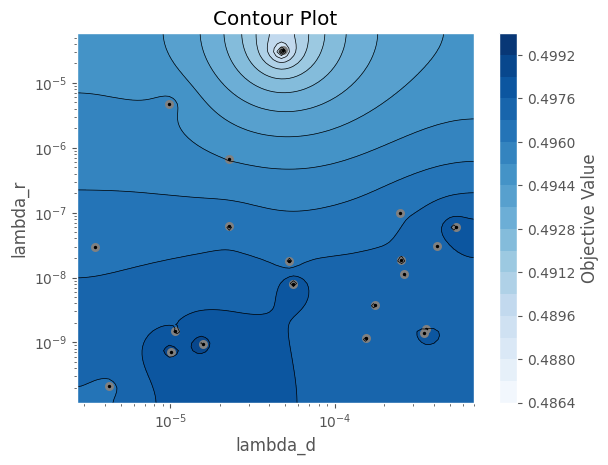

In [25]:
plot_contour(study, params=['lambda_d', 'lambda_r'])

<Axes: title={'center': 'Empirical Distribution Function Plot'}, xlabel='Objective Value', ylabel='Cumulative Probability'>

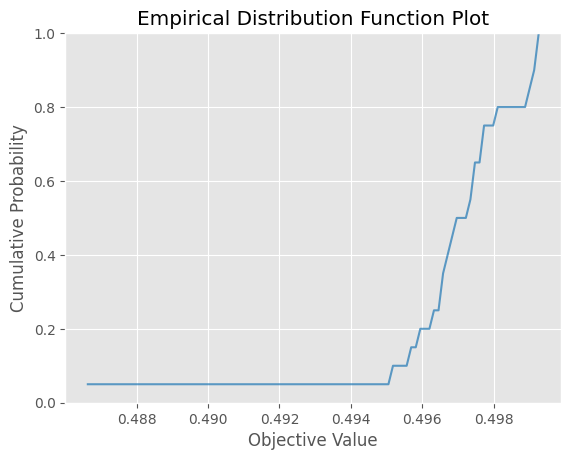

In [26]:
optuna.visualization.matplotlib.plot_edf(study)

<Axes: title={'center': 'Timeline Plot'}, xlabel='Datetime', ylabel='Trial'>

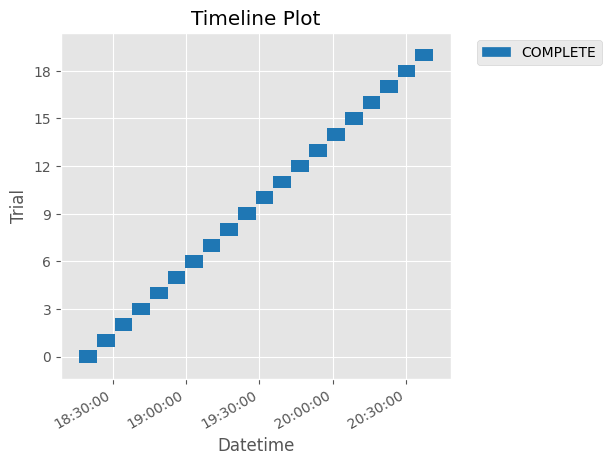

In [27]:
optuna.visualization.matplotlib.plot_timeline(study)

<Axes: title={'center': 'Timeline Plot'}, xlabel='Datetime', ylabel='Trial'>

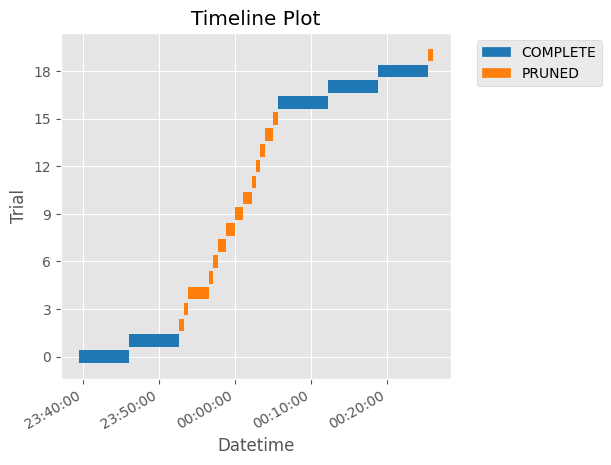

In [17]:
optuna.visualization.matplotlib.plot_timeline(study)


<Axes: title={'center': 'Intermediate Values Plot'}, xlabel='Step', ylabel='Intermediate Value'>

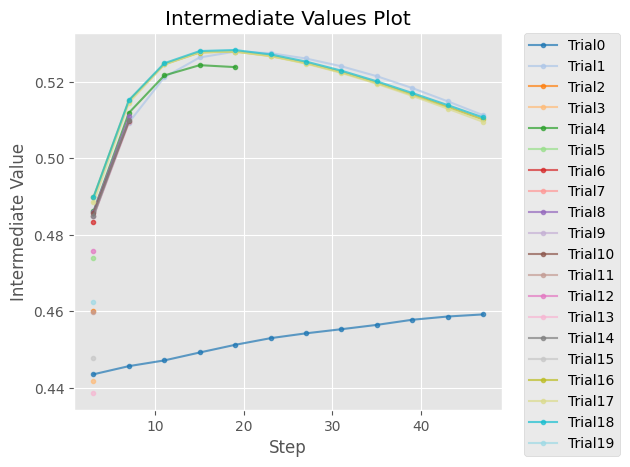

In [18]:
optuna.visualization.matplotlib.plot_intermediate_values(study)

In [19]:
with open(f"{study_path}{study_name}_best_params.yaml", "w") as f:
            yaml.dump(best_params, f, default_flow_style=False)

trials_df.to_csv(f"{study_path}{study_name}_trials.csv", index=False, sep=',') 

# Model training

In [20]:
config['lambda_sparsity_g1'] = 0
config

{'cluster_label': 'celltype',
 'lambda_count': 1e-05,
 'lambda_ct_islands': 1,
 'lambda_d': 0.001,
 'lambda_f_reg': 1e-05,
 'lambda_g1': 1,
 'lambda_g2': 1,
 'lambda_geary': 1,
 'lambda_getis_ord': 1,
 'lambda_l1': 1e-15,
 'lambda_l2': 1e-18,
 'lambda_moran': 1,
 'lambda_neighborhood_g1': 1,
 'lambda_r': 1e-09,
 'lambda_sparsity_g1': 0,
 'learning_rate': 0.1,
 'filter': False,
 'num_epochs': 50,
 'random_state': 42,
 'target_count': None}

In [ ]:
ad_map, mapper, mapper_data = tgl.map_cells_to_space(
        adata_sc=adata_sc, 
        adata_st=adata_st, 
        train_genes_names=train_genes,
        val_genes_names=val_genes,
        **config,
        )

GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs

  | Name               | Type      | Params | Mode 
---------------------------------------------------------
0 | _density_criterion | KLDivLoss | 0      | train
  | other params       | n/a       | 4.8 M  | n/a  
---------------------------------------------------------
4.8 M     Trainable params
0         Non-trainable params
4.8 M     Total params
19.052    Total estimated model params size (MB)
1         Modules in train mode
0         Modules in eval mode



Validating with 68 genes
S matrix shape: torch.Size([3661, 68])
G matrix shape: torch.Size([1301, 68])


Trainig:   0%|          | 0/1000 [00:00<?, ?it/s]


Training with 277 genes
S matrix shape: torch.Size([3661, 277])
G matrix shape: torch.Size([1301, 277])


Metric val_score improved. New best score: 0.433
Trainig:   2%|▏         | 24/1000 [03:33<2:24:39,  8.89s/it]


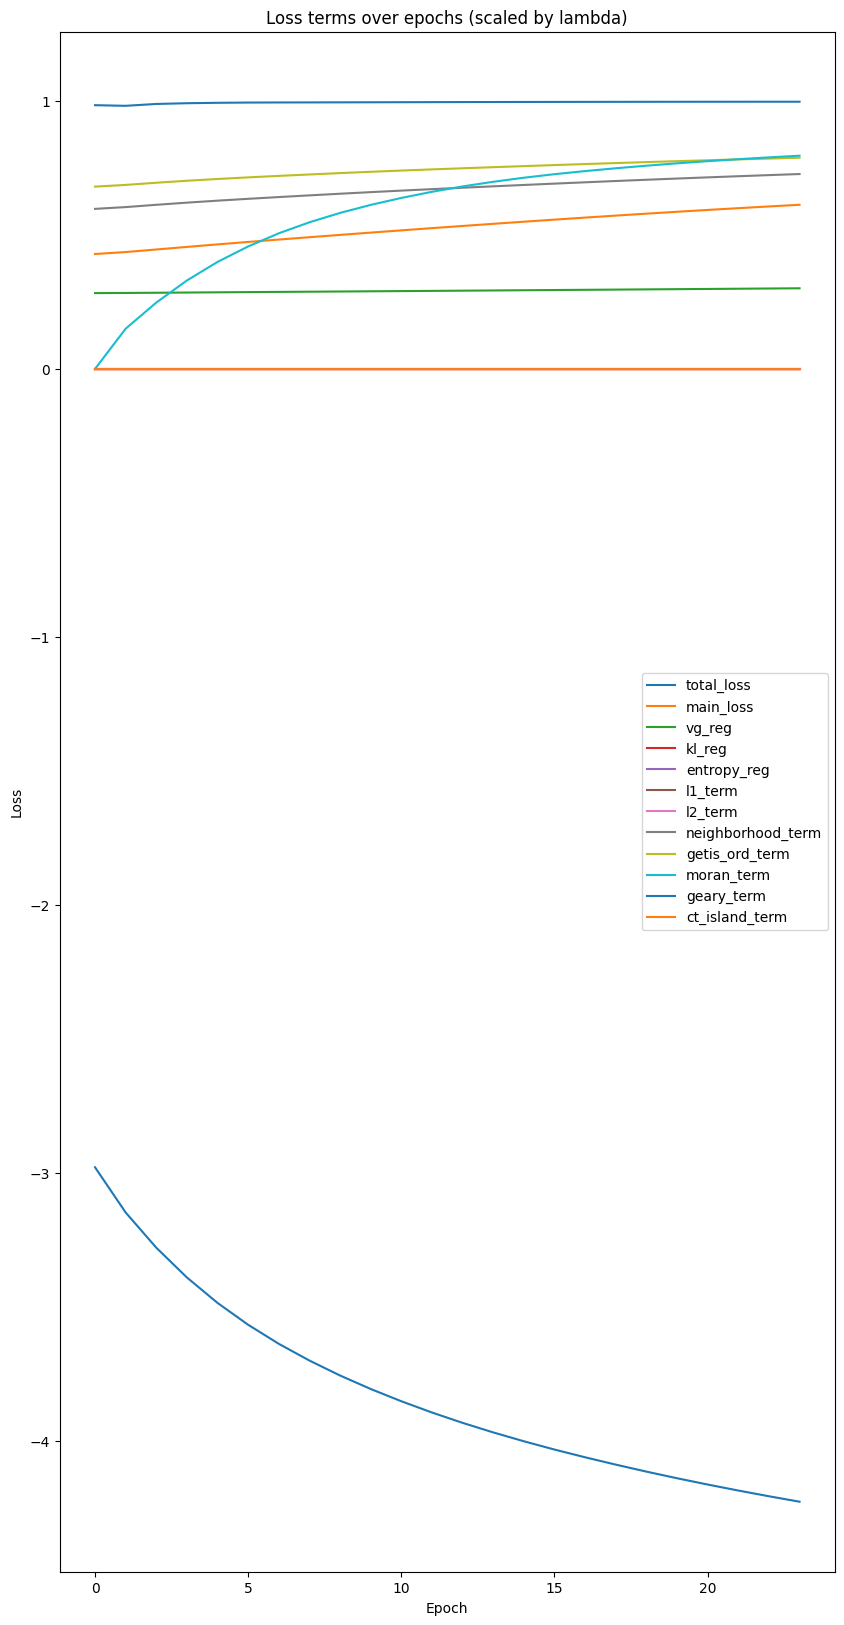

In [ ]:
tgl.plot_training_history(adata_map=ad_map, hyperparams=mapper.hparams,
                   log_scale=False, lambda_scale=True, show_total_loss=False)

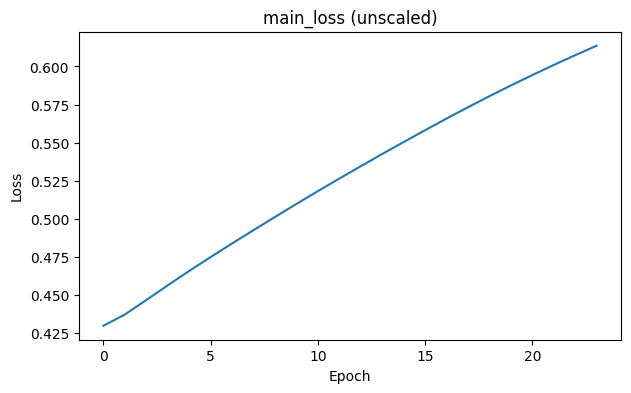

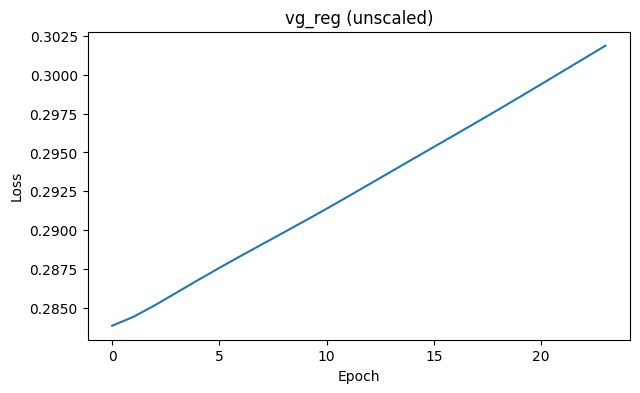

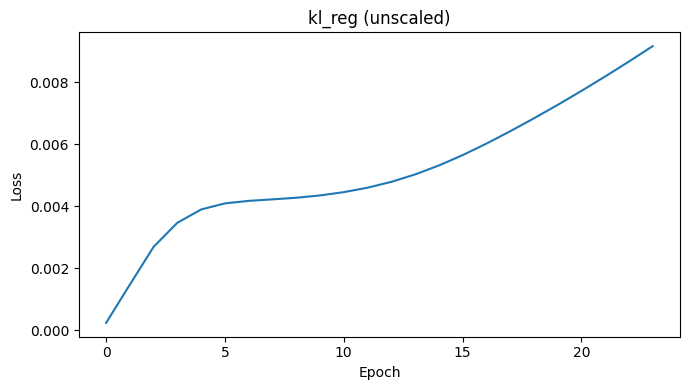

In [16]:
# Plot main loss
tgl.plot_loss_terms(adata_map=ad_map, loss_key=["main_loss", "vg_reg", "kl_reg"], 
                   lambda_coeff = [1, 1, mapper.hparams.lambda_d], lambda_scale=False)

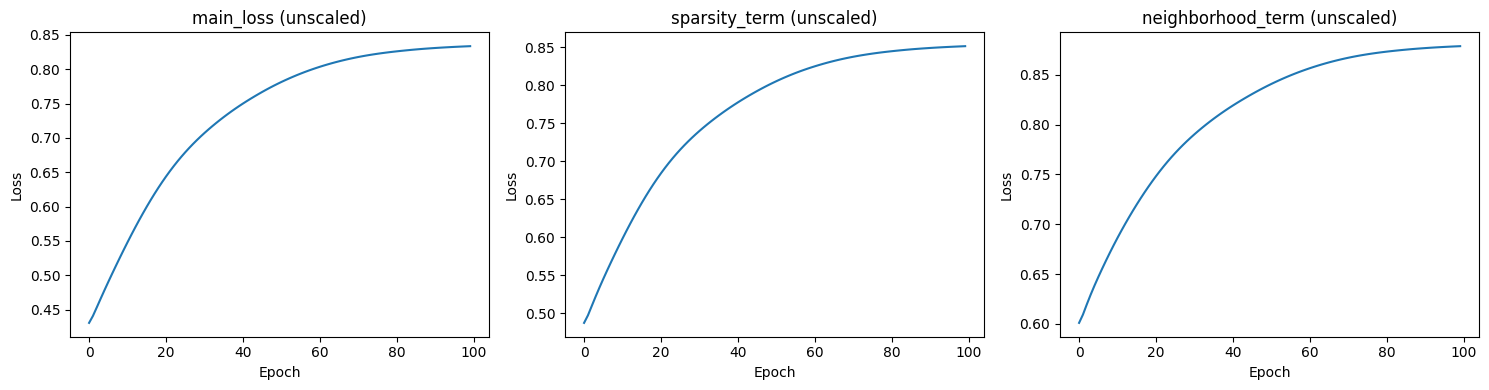

In [20]:
# Score terms
tgl.plot_loss_terms(adata_map=ad_map, loss_key=["main_loss", "sparsity_term", "neighborhood_term"], lambda_scale=False,
                   make_subplot=True, subplot_shape=(1,3))

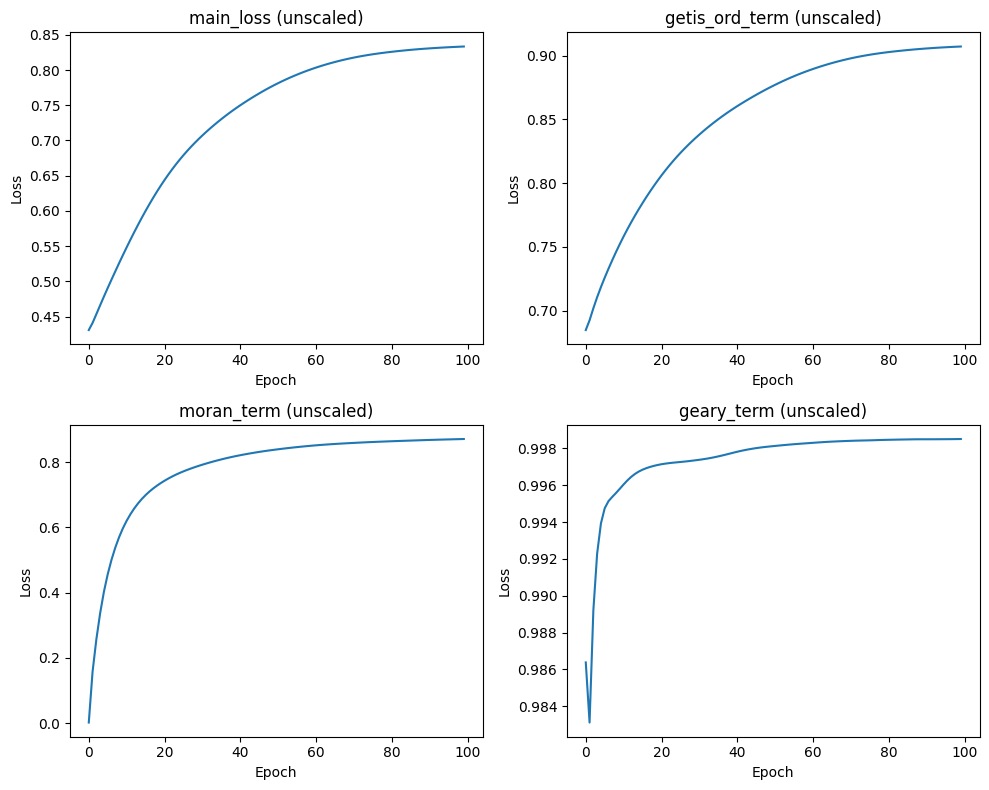

In [21]:
# LISA terms
tgl.plot_loss_terms(adata_map=ad_map, loss_key=["main_loss", "getis_ord_term", "moran_term", "geary_term"], 
                    lambda_scale=False, make_subplot=True)

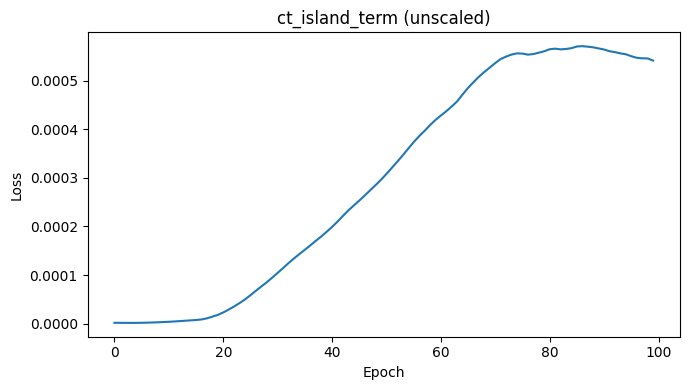

In [22]:
# CT islands term
tgl.plot_loss_terms(adata_map=ad_map, loss_key="ct_island_term", lambda_scale=False)

# Validation

💡 Tip: For seamless cloud uploads and versioning, try installing [litmodels](https://pypi.org/project/litmodels/) to enable LitModelCheckpoint, which syncs automatically with the Lightning model registry.
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs


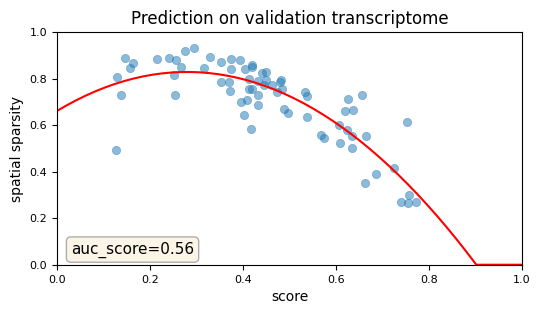

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┓
┃       Validate metric       ┃        DataLoader 0         ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┩
│           val_AUC           │     0.5599083304405212      │
│           val_JS            │     0.36161187291145325     │
│           val_PCC           │     0.24952177703380585     │
│          val_RMSE           │     1.2174111604690552      │
│          val_SSIM           │     0.19892218708992004     │
│         val_entropy         │     0.43896305561065674     │
│          val_score          │     0.45149093866348267     │
│ val_sparsity-weighted_score │    0.007466347888112068     │
└─────────────────────────────┴─────────────────────────────┘

In [23]:
# call trainer.validate()
full_val = tgl.validate_mapping_experiment(mapper, mapper_data)

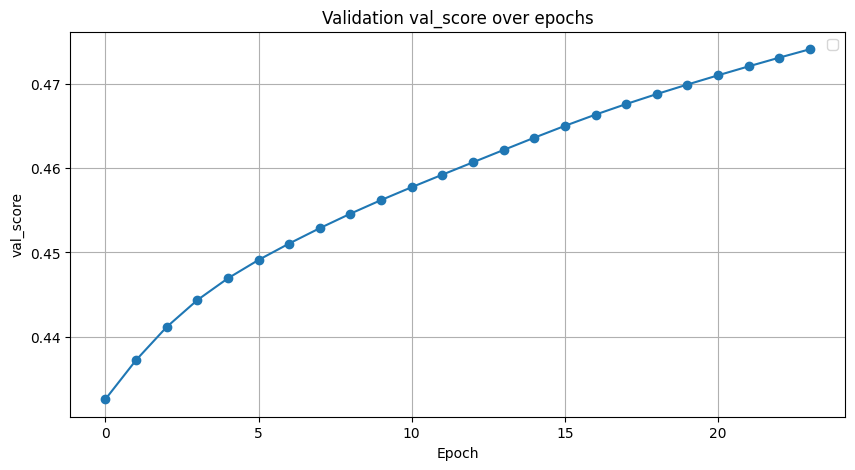

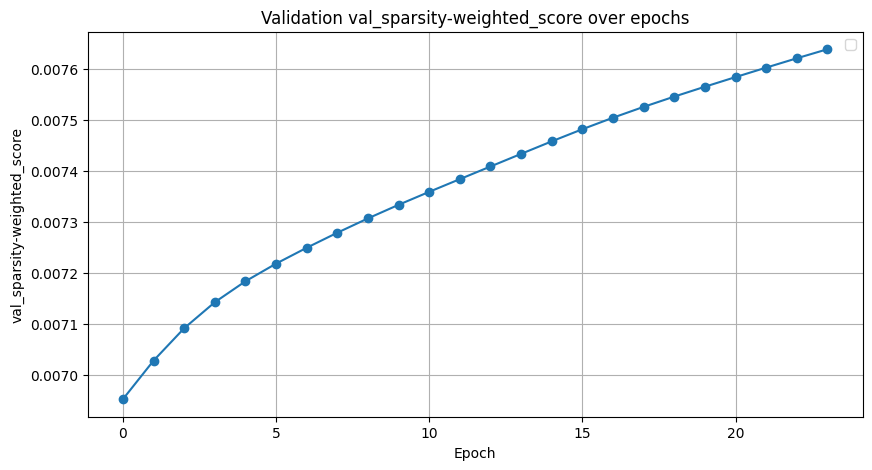

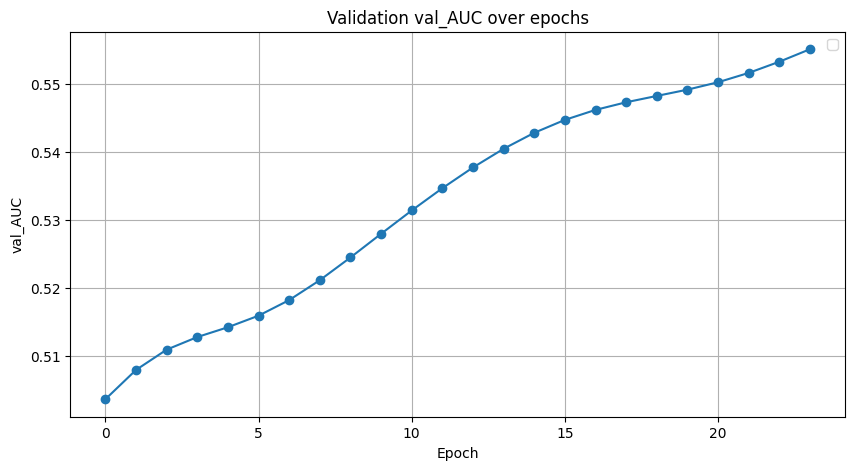

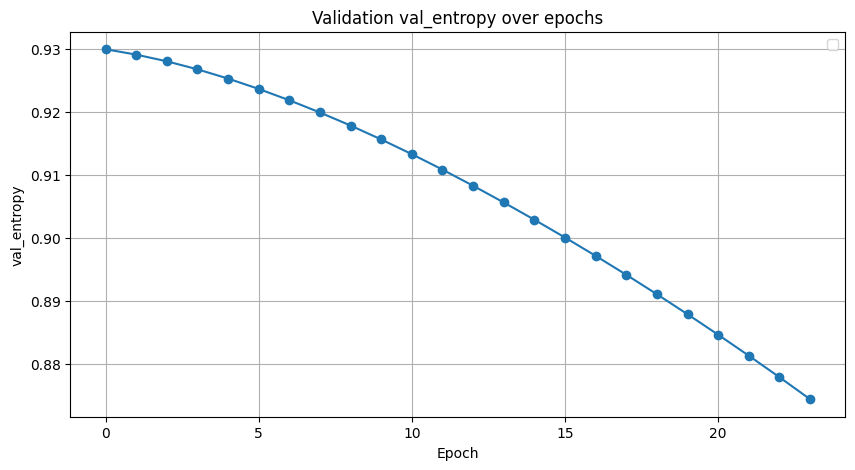

In [18]:
tgl.plot_validation_metrics_history(adata_map=ad_map)

# Sparsity

In [24]:
# Project all sc data onto spots
ad_ge = tgl.project_sc_genes_onto_space(ad_map, mapper_data)
ad_ge

AnnData object with n_obs × n_vars = 1301 × 29452
    obs: 'uniqueID', 'embryo', 'pos', 'z', 'x_global', 'y_global', 'x_global_affine', 'y_global_affine', 'embryo_pos', 'embryo_pos_z', 'Area', 'UMAP1', 'UMAP2', 'celltype_mapped_refined'
    var: 'ENSEMBL', 'SYMBOL', 'sparsity', 'is_training'
    uns: 'X_name', 'overlap_genes', 'training_genes'

In [25]:
# Create training genes scores dataframe
df = tgl.compare_spatial_gene_expr(ad_ge, mapper_data)

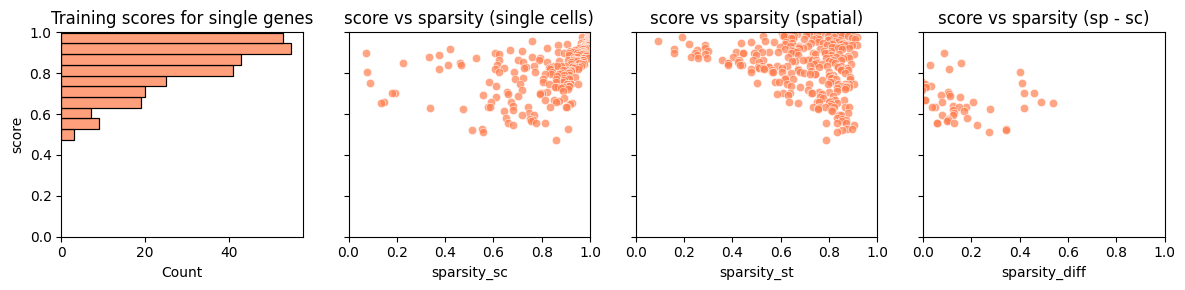

In [26]:
# Plot training scores panels
tgl.plot_training_scores(df)

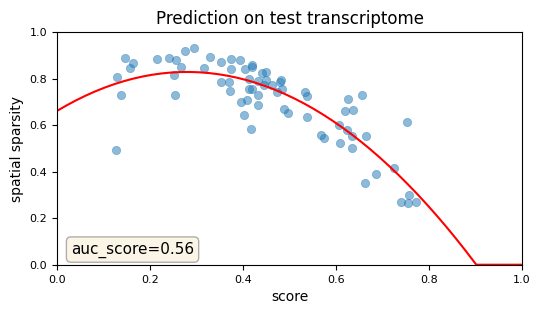

In [27]:
# Plot polyfit on test genes
tgl.plot_auc_curve(df)  # same as validation genes

# Save

In [28]:
# Write tgl.map_cells_to_space() output to .h5ad
sc.write(filename='/nfsd/sysbiobig/bazzaccoen/tangramlit_dev/results/adata_map_Dataset1', adata=ad_map, ext='h5ad')

# Optuna model

In [ ]:
# Read config yaml
with open(f"{study_path}{study_name}_best_params.yaml", "r") as f:
        opt_config = yaml.safe_load(f)

opt_config  # contains rng seed

In [23]:
ad_map, mapper, mapper_data = tgl.map_cells_to_space(
        adata_sc=adata_sc, 
        adata_st=adata_st, 
        train_genes_names=train_genes,
        val_genes_names=val_genes,
        lambda_g1=1,
        lambda_sparsity_g1=0,
        learning_rate=0.1,
        num_epochs=1000,
        filter=False,
        cluster_label='celltype',
        **opt_config,
        )

GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs

  | Name               | Type      | Params | Mode 
---------------------------------------------------------
0 | _density_criterion | KLDivLoss | 0      | train
  | other params       | n/a       | 4.8 M  | n/a  
---------------------------------------------------------
4.8 M     Trainable params
0         Non-trainable params
4.8 M     Total params
19.052    Total estimated model params size (MB)
1         Modules in train mode
0         Modules in eval mode



Validating with 69 genes
S matrix shape: torch.Size([3661, 69])
G matrix shape: torch.Size([1301, 69])


Trainig:   0%|          | 0/1000 [00:00<?, ?it/s]


Training with 276 genes
S matrix shape: torch.Size([3661, 276])
G matrix shape: torch.Size([1301, 276])


Metric val_score improved. New best score: 0.449
Trainig:   2%|▏         | 17/1000 [02:38<2:32:31,  9.31s/it]


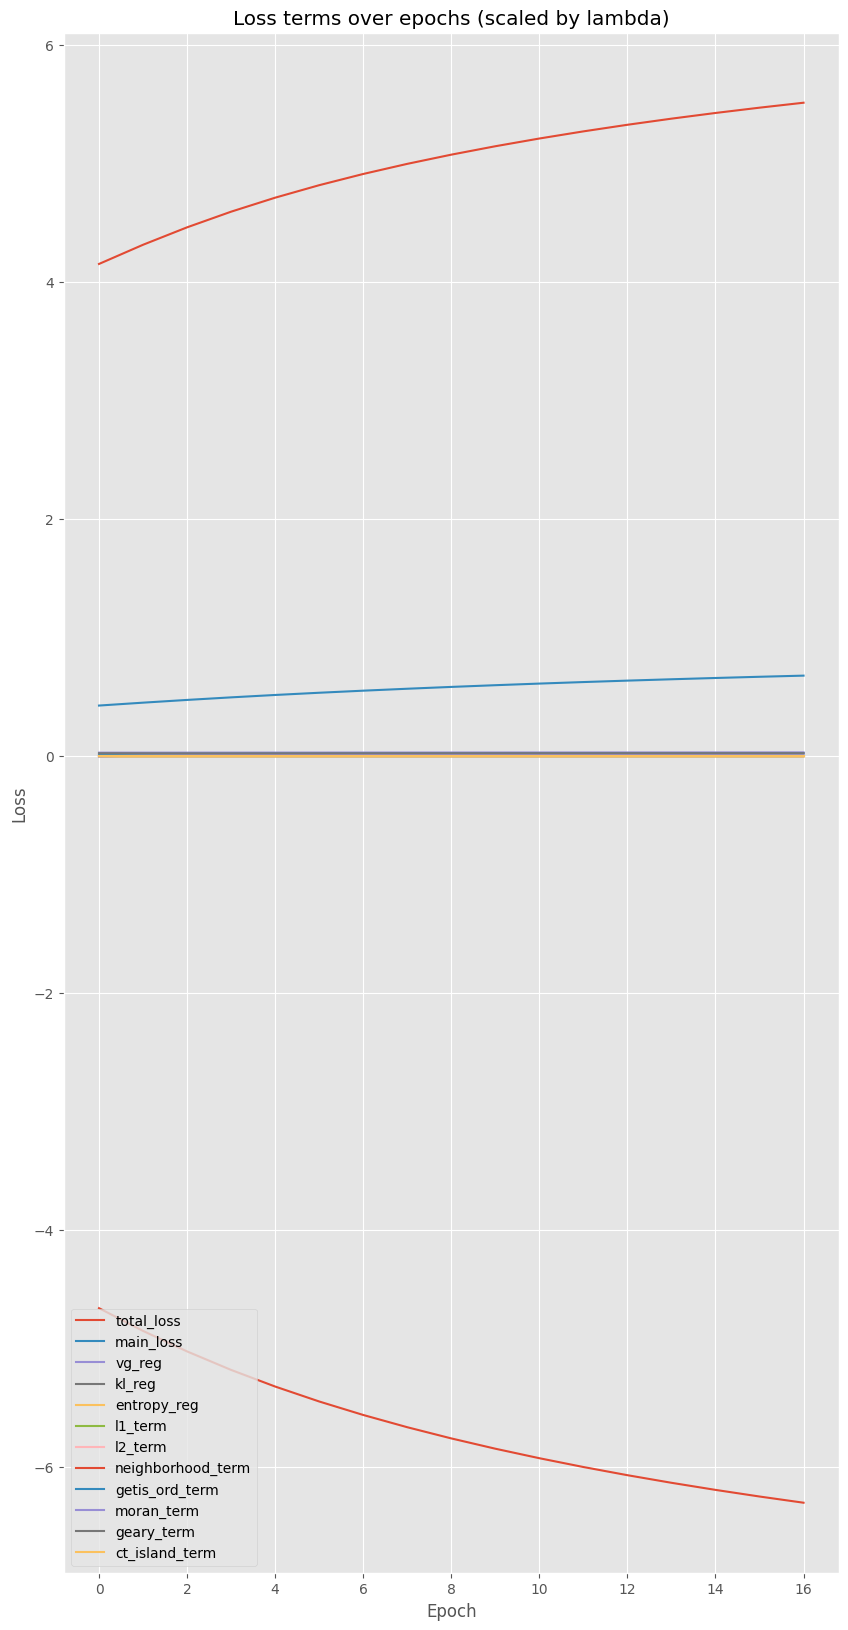

In [27]:
tgl.plot_training_history(adata_map=ad_map, hyperpams=mapper.hparams,
                   log_scale=False, lambda_scale=True, show_total_loss=False)

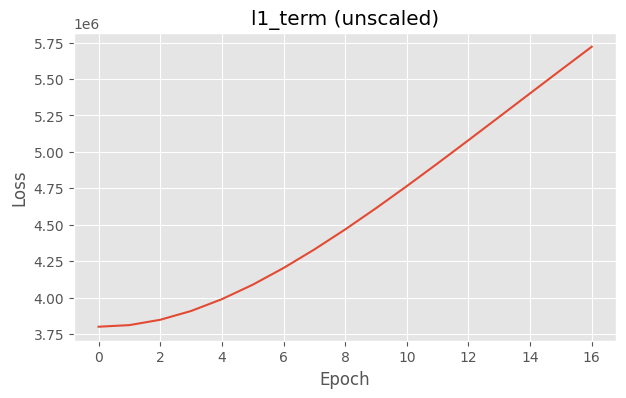

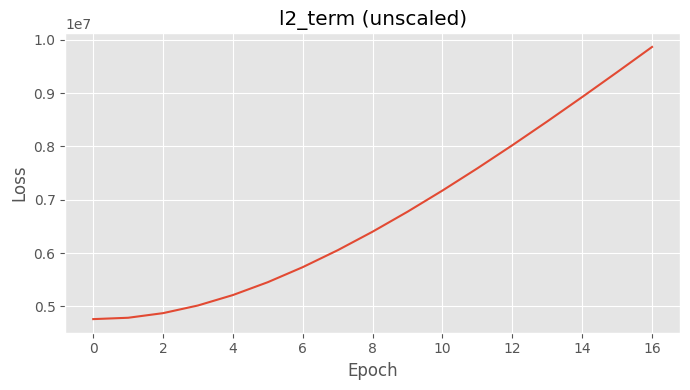

In [28]:
tgl.plot_loss_terms(adata_map=ad_map, loss_key=["l1_term", "l2_term"], 
                   lambda_coeff = [mapper.hparams.lambda_l1, mapper.hparams.lambda_l2], lambda_scale=False)

In [31]:
ad_map.uns['training_history']['l1_term'][0]

3.997814232437058e-12

💡 Tip: For seamless cloud uploads and versioning, try installing [litmodels](https://pypi.org/project/litmodels/) to enable LitModelCheckpoint, which syncs automatically with the Lightning model registry.
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs


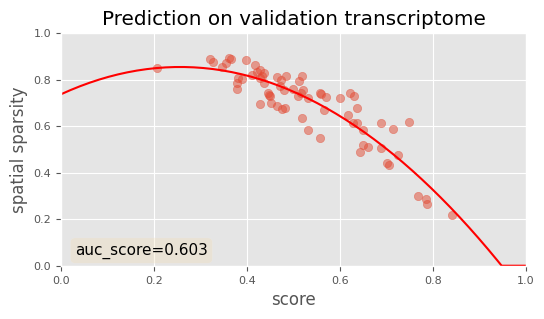

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┓
┃       Validate metric       ┃        DataLoader 0         ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┩
│           val_AUC           │     0.6028192043304443      │
│           val_JS            │     0.32802310585975647     │
│           val_PCC           │     0.33113279938697815     │
│          val_RMSE           │     1.1474778652191162      │
│          val_SSIM           │     0.1545654535293579      │
│         val_entropy         │      0.841630756855011      │
│          val_score          │      0.524824857711792      │
│ val_sparsity-weighted_score │     0.00846183579415083     │
└─────────────────────────────┴─────────────────────────────┘

In [24]:
full_val = tgl.validate_mapping_experiment(mapper, mapper_data)

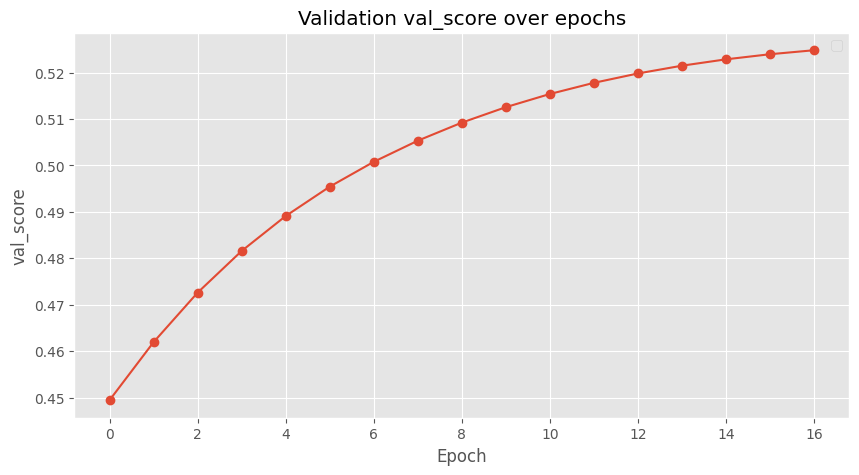

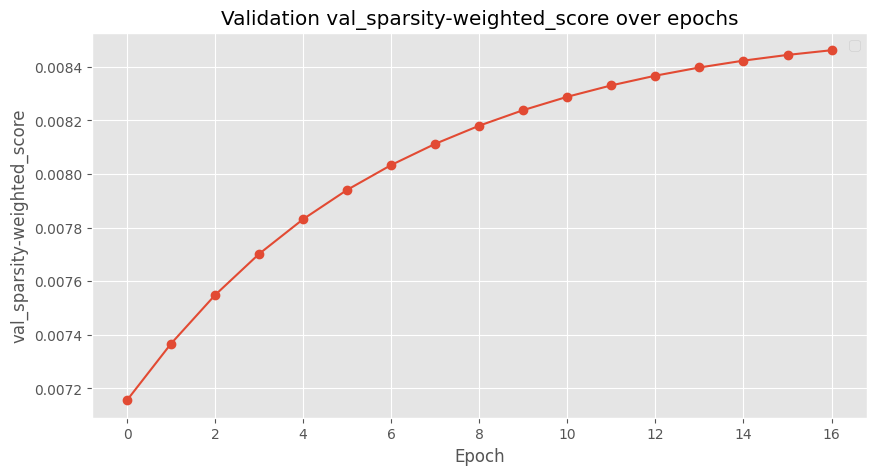

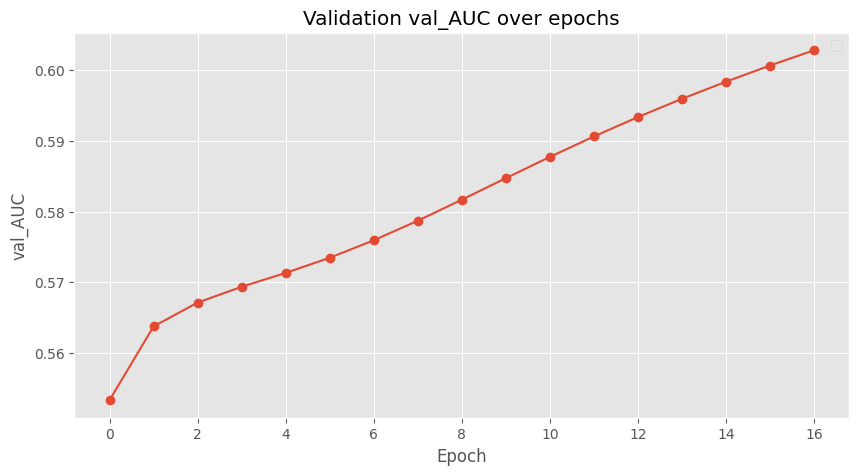

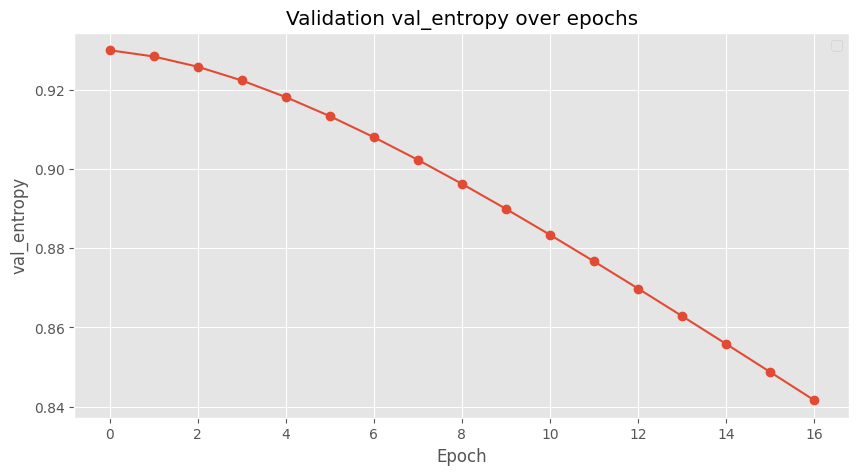

In [25]:
tgl.plot_validation_metrics_history(adata_map=ad_map)